In [ ]:
import pandas as pd
from tqdm import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk
from nltk import word_tokenize 
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def clean_text(text):
    
    """
        text: a string
        return: modified initial string
    """
    
    cleaner = re.compile('<.*?>')
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))

    text = re.sub(cleaner, ' ', text)
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords
    return text

In [ ]:
def get_data():

    """
       Description: get_data imports pre-classified data set, the data set contains 
                    Job titles, Job descriptions and education_level.

       Pre_processing: The imported dataset goes through pre-processing,
                       pre-processing contains,
                       - Deduplication.
                       - Combining job titles and job description.
    """
    
    df = pd.read_csv('/content/drive/MyDrive/jobs_data_with_title.csv')
    df.columns=['', 'title', 'description', 'category']

    df = df.drop_duplicates(subset =["title", "description"])

    df.reset_index(inplace = True, drop = True)

    # Combining job_title and job description
    df['combine_text']=df['title']+' '+df['description']

    # Apply text cleaning
    df['combine_text'] = df['combine_text'].apply(clean_text)

    return df

In [ ]:
# get_data
main_data = get_data()
print(main_data.shape)

(5187, 5)


In [ ]:
main_data

...                                       combine_text
0        0  ...  medical assistant part time hiring medical ass...
1        1  ...  cpr bls instructor hiring looking prn instruct...
2        2  ...  cna certified nursing assistant hiring ascensi...
3        3  ...  educator cpd pct service line hiring educatorp...
4        4  ...  nurse tech float pool hospitals wichita hiring...
...    ...  ...                                                ...
5182  5182  ...  mental health professional wellpath everything...
5183  5183  ...  therapistbehavioral health hiring mondayfriday...
5184  5184  ...  assistant nurse manager rn emergency departmen...
5185  5185  ...  bilingual forensic interviewer days broadview ...
5186  5186  ...  technical specialist battery module leading fu...

[5187 rows x 5 columns]

# TEXT split

In [ ]:
X = main_data
y = main_data.category

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, stratify=y)

In [ ]:
print("main_data", X.shape, y.shape)
print("Xtrain", xtrain.shape, ytrain.shape)
print("Xtest", xtest.shape, ytest.shape)

main_data (5187, 5) (5187,)
Xtrain (3475, 5) (3475,)
Xtest (1712, 5) (1712,)


# TEXT Pre processing 


In [ ]:
with open('/content/drive/My Drive/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

AVG_Word_2_vec

In [ ]:
# average word_2_vec
# compute average word2vec for each job.

def get_avg_word_vec(text_column):

    Xtrain_job_avg_w2v_vectors = []; 
    for sentence in text_column:
        vector = np.zeros(300)
        cnt_words =0;
        for word in sentence.split():
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        Xtrain_job_avg_w2v_vectors.append(vector)

    return Xtrain_job_avg_w2v_vectors


Xtrain_avg_w2v_vector = get_avg_word_vec(xtrain['combine_text'])
Xtest_avg_w2v_vector = get_avg_word_vec(xtest['combine_text'])

Word_2_vec

In [ ]:
# word_2_vec

def get_word_vec(text_column):

    Xtrain_job_avg_w2v_vectors = []; 
    for sentence in text_column:
        vector = np.zeros(300)

        for word in sentence.split():
            if word in glove_words:
                vector += model[word]

        Xtrain_job_avg_w2v_vectors.append(vector)

    return Xtrain_job_avg_w2v_vectors


Xtrain_w2v_vector = get_word_vec(xtrain['combine_text'])
Xtest_w2v_vector = get_word_vec(xtest['combine_text'])

TFIDF vectorizer

In [ ]:
vectorizer = TfidfVectorizer(min_df=10,max_features=3000)


xtrain_tfidf = vectorizer.fit_transform(xtrain['combine_text'])
xtest_tfidf = vectorizer.transform(xtest['combine_text'])

MODEL


In [ ]:
iterations = [100,200,300,400,500,600,700,800,900,1000]

train_error = []
test_error = []

for i in iterations:
    clf = SGDClassifier(learning_rate='constant',eta0=0.01,penalty=None, max_iter= i ,fit_intercept=True)
    clf.fit(xtrain_tfidf, ytrain)

    y_train_pred = clf.predict(xtrain_tfidf)
    train_error.append(accuracy_score(y_train_pred, ytrain))

    y_test_pred = clf.predict(xtest_tfidf)
    test_error.append(accuracy_score(y_test_pred, ytest))


plt.figure(figsize=[20.0,10.0])

plt.plot(iterations, train_error, label= ' Train error')
plt.scatter(iterations, train_error, label= ' Train error points')

#details of error plot
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("Iterations Vs error plot")
plt.grid()
plt.show()

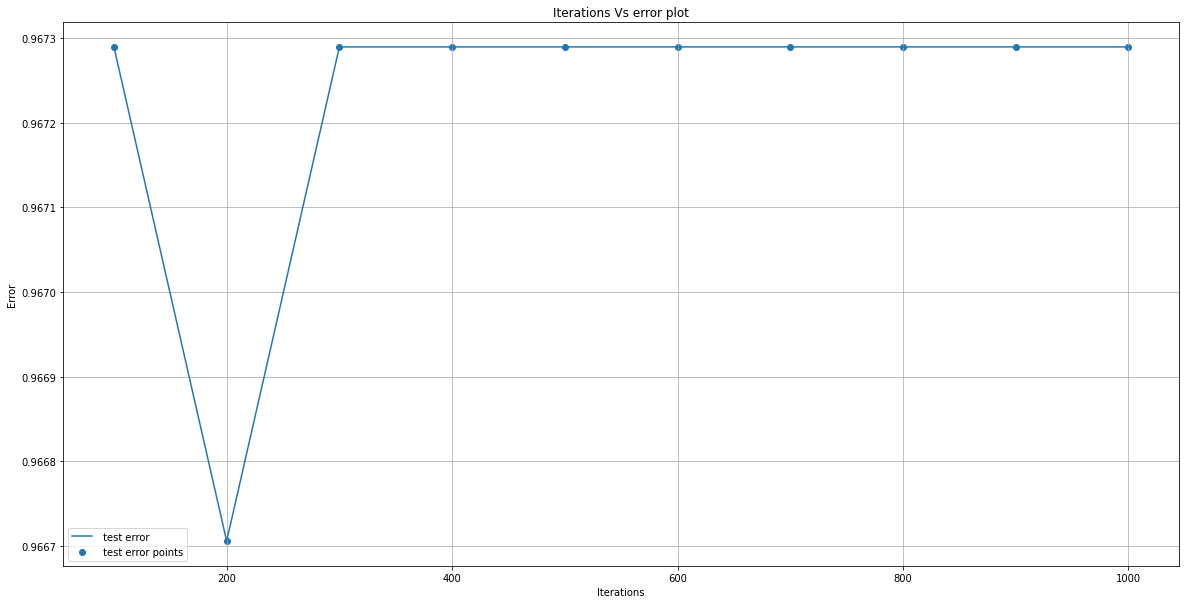

In [ ]:
plt.figure(figsize=[20.0,10.0])

plt.plot(iterations, test_error, label= ' test error')
plt.scatter(iterations, test_error, label= ' test error points')

#details of error plot
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("Iterations Vs error plot")
plt.grid()
plt.show()

In [ ]:
Classifier = SGDClassifier(alpha=1e-04, loss='log', random_state=30,early_stopping=True, tol=None,n_jobs=-1, verbose=1)
Classifier.fit(xtrain_tfidf, ytrain)

In [ ]:
y_train_pred = Classifier.predict(xtrain_tfidf)
print('train accuracy %s' % accuracy_score(y_train_pred, ytrain))

y_test_pred = Classifier.predict(xtest_tfidf)
print('test accuracy %s' % accuracy_score(y_test_pred, ytest))

train accuracy 0.9864748201438849
test accuracy 0.9742990654205608
